# Looking for ortholog ID families with conserved compactness across lenght variations

In [10]:
# Imports
from Bio import SeqIO
import json
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
import requests

sys.path.append('../../src')
import data_utils
import analyse_utils
import mdtraj as md

## Data preparation

In [154]:
# Querying API
orthodb_e1a_group = '19343at10239' 
url = f"https://data.orthodb.org/current/orthologs?id={orthodb_e1a_group}"
data = requests.get(url).json()

In [165]:
# Parsing response
# Extracting UniProt IDs
uids = []
uids_species = []
no_uids_ids = []
no_uids_species = []
for id in range(len(data['data'])):

    # Skipping species without UniProt entries
    try:
        for protein in data['data'][id]['genes']:
            uids.append(protein['uniprot']['id'])
            uids_species.append(data['data'][id]['organism']['name'])
    except KeyError:
        no_uids_ids.append(data['data'][id]['genes'][0]['gene_id']['param'])
        no_uids_species.append(data['data'][id]['organism']['name']) 

# Handling proteins with no UniProt IDs
if no_uids_species:
    print(f"The following {len(no_uids_species)}/{len(data['data'])} entries had no UniProt IDs")
    print(*[f" - {specie}" for specie in no_uids_species], sep="\n")

# Defining UniProt IDs
orthologs = pd.DataFrame({'uniprot_id': uids,
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None})

The following 5/28 entries had no UniProt IDs
 - Human mastadenovirus A
 - Human mastadenovirus B
 - Human mastadenovirus D
 - Human mastadenovirus F
 - Tree shrew adenovirus 1


In [166]:
# Collecting metadata
deleted_records = []
for id, row in orthologs.iterrows():
    try:
        name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    except:
        deleted_records.append(id)
        continue
    orthologs.loc[id] = {
            'uniprot_id': row.uniprot_id,
            'name': name,
            'description': desc,
            'species': spec,
            'sequence': seq}
    
# Discarding deleted UniProt records
if deleted_records:
    print(f"The following {len(deleted_records)}/{len(orthologs)} UniProt IDs returned no records:")
    for id in deleted_records:
        print(f" - {orthologs.loc[id].uniprot_id}")
    orthologs.drop(index=deleted_records, inplace=True)

# Extracting host
orthologs['host'] = orthologs.species.apply(lambda species: species.split(' ')[0])

The following 1/23 UniProt IDs returned no records:
 - Q695T6


In [167]:
# Getting IDR linkers
not_linker = []
linker_seqs = []
linker_locs = []
for id, row in orthologs.iterrows():
    try:
        seq, loc, reg = data_utils.get_protein_idr(uniprot_id=row.uniprot_id, i_idr=0, length_order=True)
        if reg != 'INT':
            not_linker.append((id, row.uniprot_id))
        else:
            linker_seqs.append(seq)
            linker_locs.append(loc)
    except ValueError:
        not_linker.append((id, row.uniprot_id))
if not_linker:
    print(f"The following {len(not_linker)}/{len(orthologs)} UniProt IDs did not return intrinsically disordered linker regions:")
    for id, uid in not_linker:
        print(f" - {uid}")
        orthologs.drop(index=id, inplace=True)
orthologs['linker_sequence'] = linker_seqs
orthologs['linker_location'] = linker_locs

The following 9/22 UniProt IDs did not return intrinsically disordered linker regions:
 - A0A1B0UHZ2
 - A0A1X9RIQ2
 - A0A1X9RIS6
 - Q64842
 - A0A059XN88
 - Q5UW25
 - Q5C8R3
 - A0A0M4MQM5
 - A0A1L3INV8


In [173]:
# Displaying final linkers
orthologs

,uniprot_id,name,description,species,sequence,host,linker_sequence,linker_location
5,G9G840,G9G840_9ADEN,Early E1A protein,Chimpanzee adenovirus Y25,MRHLRDLPDEKIIIASGNEILELVVNAMMGDDPPEPPTPFEAPSLH...,Chimpanzee,ALLAAEEASSPSSDSDSSLHTPRPGRGEKKIPELK,72:107
6,B9A5L3,B9A5L3_9ADEN,Early E1A protein,Human adenovirus 54,MRHLHLLSSTVPIDMAALLLEDYVNTILEDELHLSPFELGPTLQDL...,Human,EDESSPLEEDHPSPPDLTNDTPLQVRKPTPVRPSGERR,187:225
8,J9Z5B4,J9Z5B4_9ADEN,Early E1A protein,Human mastadenovirus C,MRHIICHGGVITEEMAASLLDQLIEEVLADNLPPPSHFEPPTLHEL...,Human,VSEPEPEPEPEPEPARPTRRPKLVPAILRRPTSPVSRECNSSTDSC...,186:245
9,Q6H1D8,Q6H1D8_9ADEN,Early E1A protein,Human mastadenovirus E,MRHLRDLPDEEIIIASGSEILELVVNAMMGDDHPEPPTPFETPSLH...,Human,VSDADDETPTTESTLSPPEIGTSPSDNIVRP,190:221
11,A0A0M4NFL9,A0A0M4NFL9_9ADEN,Early E1A protein,Simian adenovirus 13,MRTPLVEGDIPVRFAAELLAALAEEVFADVEPPRAFEDVSLHDLFD...,Simian,EAEVDEPDTTTDDQGRAQSPPKLTQDAPVNVIRPRPIRPSSRRRNAVDS,201:250
12,A0A0M4MEX3,A0A0M4MEX3_9ADEN,Early E1A protein,Simian adenovirus 16,MRHLALEMISELLDLGLDTIDGWLHTEFAPVPAGVSHNMSLHEMYD...,Simian,VSDSEPDEPDSTTADSNHGSPPTLRCTPPRDLPRPVPVKASPGKRP...,192:244
13,H8PFZ0,H8PFZ0_9ADEN,Early E1A protein,Simian adenovirus 18,MRMLPEIFTGSWEDVFQGLLESEDNFPQPPEPEELPEVSLHDLFDV...,Simian,DAEGDSESPAGPSQPSPCSLTATP,182:206
15,F6KST5,F6KST5_9ADEN,Early E1A protein,Simian adenovirus 20,MRNFILSPGLPPTVAAELLEDIVSGALGDDPQVISHFCDDFSLHDL...,Simian,EEPDSTTGSVDDKPSPPQMTEKPERPRPNILKPKPQRVSSRRR,197:240
17,F2WTJ6,F2WTJ6_9ADEN,Early E1A protein,Simian adenovirus 49,MKTWGLDCGLYPQEVDEWLRTEYCPTPGYYGENLSLHDLYDIDVDA...,Simian,DAEGEPDSTTGHSGGPGSPPKLHNTPPRNVPRPVPLR,195:232
18,A0A0M5L3X1,A0A0M5L3X1_9ADEN,Early E1A protein,Simian adenovirus 8,MKTWGLDCGLNLLEVDEWLRTEFCPTPGYYGENLSLHDLYDLDVDG...,Simian,DADGEPDSTTGNSGGPGSPPKLHNTPPKNVPRPVPV,195:231


## Analysis

In [2]:
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams["font.weight"] = "normal"

### E1A - Sanity checking

#### Preparing SVR model and features

In [55]:
import itertools
from localcider.sequenceParameters import SequenceParameters
from residues import residues

# Loading SVR model
import joblib
model = joblib.load('svr_model.joblib')

def svr_features(seq,Nc=0,Cc=0,Hc=0.5,residues=residues.set_index('one')):
    """df: DataFrame to be populated with sequence properties
    r: DataFrame of aa-specific parameters"""
    seq = list(seq).copy()   
    fasta_kappa = np.array(seq.copy())
    N = len(seq)
    r = residues.copy()
    
    # calculate properties that do not depend on charges
    mean_lambda = np.mean(r.loc[seq].AH_lambda)

    pairs = np.array(list(itertools.combinations(seq,2)))
    pairs_indices = np.array(list(itertools.combinations(range(N),2)))
    # calculate sequence separations
    ij_dist = np.diff(pairs_indices,axis=1).flatten().astype(float)
    # calculate lambda sums
    ll = r.AH_lambda.loc[pairs[:,0]].values+r.AH_lambda.loc[pairs[:,1]].values
    # calculate SHD
    beta = -1
    shd = np.sum(ll*np.power(np.abs(ij_dist),beta))/N
    SeqOb = SequenceParameters(''.join(seq))
    
    # fix charges
    if Nc == 1:
        r.loc['X'] = r.loc[seq[0]]
        r.loc['X','q'] = r.loc[seq[0],'q'] + 1.
        seq[0] = 'X'
        if r.loc['X','q'] > 0:
            fasta_kappa[0] = 'K'
        else:
            fasta_kappa[0] = 'A'
    if Cc == 1:
        r.loc['Z'] = r.loc[seq[-1]]
        r.loc['Z','q'] = r.loc[seq[-1],'q'] - 1.
        seq[-1] = 'Z'
        if r.loc['Z','q'] < 0:
            fasta_kappa[-1] = 'D'
        else:
            fasta_kappa[-1] = 'A'
    if Hc < 0.5:
        r.loc['H', 'q'] = 0
        fasta_kappa[np.where(np.array(seq) == 'H')[0]] = 'A'
    elif Hc >= 0.5:
        r.loc['H', 'q'] = 1
        fasta_kappa[np.where(np.array(seq) == 'H')[0]] = 'K'
            
    # calculate properties that depend on charges
    pairs = np.array(list(itertools.combinations(seq,2)))
    # calculate charge products
    qq = r.q.loc[pairs[:,0]].values*r.q.loc[pairs[:,1]].values
    # calculate SCD
    scd = np.sum(qq*np.sqrt(ij_dist))/N
    SeqOb = SequenceParameters(''.join(fasta_kappa))
    kappa = SeqOb.get_kappa()
    fcr = r.q.loc[seq].abs().mean()

    return np.array([scd, shd, kappa, fcr, mean_lambda])

def predict_nu(seq):
    features = svr_features(seq).reshape(1, -1)
    nu = float(model.predict(features))
    return nu

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator SVR from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


#### From Gonzáles-Foutel paper

In [8]:
# Loading metadata
gonzales = analyse_utils.load_metadata('../e1a_linkers/e1a_linkers.json', join=False)[0]
gonzales

,sequence,host
CA_CAdV1_linker,ELENSRSPSPLLCDWCAEADSESTISTETDVGFTLNTPPVSPLPSY...,CA
HA_HAdV31_linker,DVESAGEDSNEQAVNDFFPESFILAAAEGVILPEPPVLSPICEPIG...,HA
HC_SAdV34_linker,DVVGPSDPNEQAVSSFFPESMLLASQEGVELETPPPIVDSPDPPQL...,SA
HE_SAdV22_linker,EVDVPENDPNEEAVNDLFSDAALLAAEQANTDSGSDSDSSLHTPRP...,SA
HG_HAdV52_linker,EVDPPQDPNEDAVNSMFPECLFEAAEEGSHSSEESKRGEEL,HA
SA_SAdV20_linker,DPGTETETDPLATAVDEFFPESMLLEADMPPHLESPVQPGAGGAMP...,SA
BA_BAdV1_linker,DDASDVVSLFFPELEVQQDLPTAEEVED,BA
CA_CAdV2_linker,ELETSHSPFVGLCDSCAEADTDSSASTEADSGFSPLSTPPVSPIPP...,CA
HB_HAdV11_linker,EVEGSEDSNEEAVNGFFTDSMLLAANEGLELDPPLDTFDTPGVIVE...,HA
HC_SAdV43_linker,DVLVDVNDPNEEAVSTFFPESALLAAQEGFDLHTPPLPILESPLPE...,SA


In [9]:
# Loading trajectories
gonzales['traj'] = gonzales.apply(lambda row: md.load_dcd(*['/'.join(['../e1a_linkers/results', row.name, filename]) for filename  in ['traj.dcd', 'top.pdb']]), axis=1)

In [10]:
# Computing sequence lengths
gonzales['length'] = gonzales.apply(lambda row: len(row.sequence), axis=1)
gonzales.sort_values('length', inplace=True)

In [12]:
# Computing scaling exponent
gonzales['nu_'] = gonzales.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj)[0], axis=1)
gonzales['nu'] = gonzales.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, r0_fix=None)[0], axis=1)
gonzales['R0'] = gonzales.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, r0_fix=None)[1], axis=1)

In [59]:
# Predicting scaling exponent
gonzales['nu_svr'] = gonzales.apply(lambda row: predict_nu(row.sequence), axis=1)

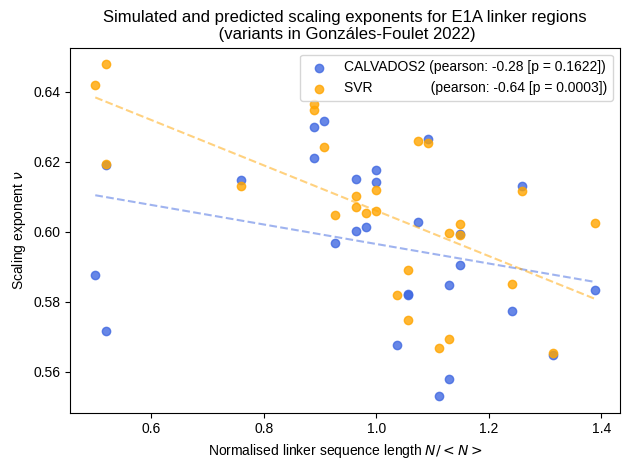

In [108]:
# Correlation
corr_calvados, p_corr_calvados = pearsonr(gonzales.length, gonzales.nu)
corr_svr, p_corr_svr = pearsonr(gonzales.length, gonzales.nu_svr)


# Plotting
plt.scatter(gonzales.length/gonzales.length.mean(), gonzales.nu,     label=f'CALVADOS2 (pearson: {corr_calvados:.2f} [p = {p_corr_calvados:.4f}])', c='royalblue', alpha=0.8)
plt.scatter(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, label=f'SVR               (pearson: {corr_svr:.2f} [p = {p_corr_svr:.4f}])',       c='orange', alpha=0.8)

N = np.array([gonzales.length.min()/gonzales.length.mean(), gonzales.length.max()/gonzales.length.mean()])
slope_calvados, intersect_calvados = np.polyfit(gonzales.length/gonzales.length.mean(), gonzales.nu, 1)
plt.plot(N, N*slope_calvados+intersect_calvados, c='royalblue', alpha=0.5, linestyle='--')
slope_svr, intersect_svr = np.polyfit(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, 1)
plt.plot(N, N*slope_svr+intersect_svr, c='orange', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel("Normalised linker sequence length $N/<N>$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title("Simulated and predicted scaling exponents for E1A linker regions\n (variants in Gonzáles-Foulet 2022)")

plt.tight_layout()

#### From OrthoDB

In [176]:
# Setting OrthoDB variants
orthodb = orthologs[['linker_sequence']]
orthodb.columns= ['sequence']
orthodb.index = orthologs['name']

In [ ]:
# Computing sequence lengths
orthodb['length'] = orthodb.apply(lambda row: len(row.sequence), axis=1)
orthodb.sort_values('length', inplace=True)

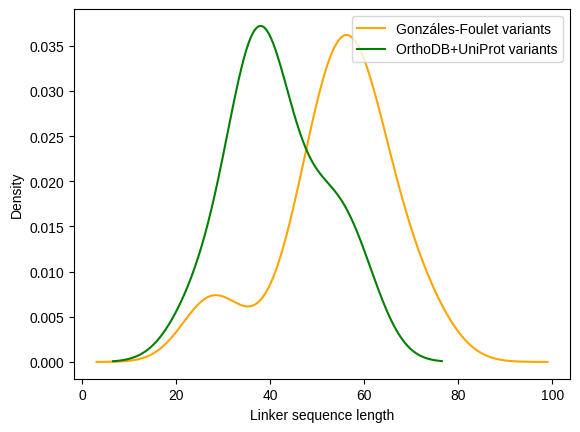

In [205]:
# Checking length distributions
gonzales.length.plot.density(color='orange', label='Gonzáles-Foulet variants')
orthodb.length.plot.density(color='green', label='OrthoDB+UniProt variants')
plt.xlabel("Linker sequence length")
plt.legend(loc='upper right')

In [ ]:
# Predicting scaling exponent
orthodb['nu_svr'] = orthodb.apply(lambda row: predict_nu(row.sequence), axis=1)

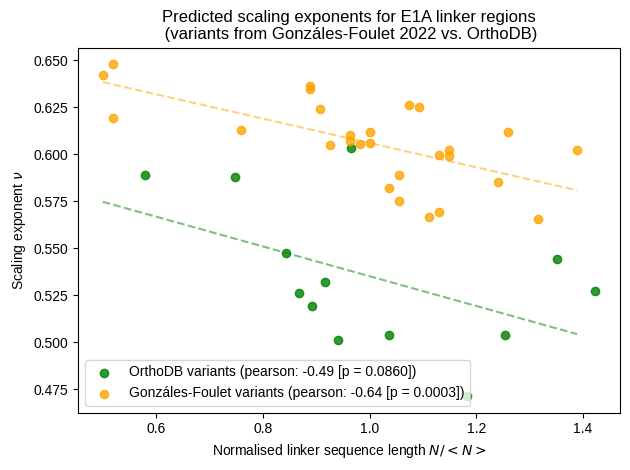

In [181]:
# Correlation
corr_orthodb, p_corr_orthodb = pearsonr(orthodb.length, orthodb.nu_svr)
corr_gonzales, p_corr_gonzales = pearsonr(gonzales.length, gonzales.nu_svr)


# Plotting
plt.scatter(orthodb.length/orthodb.length.mean(), orthodb.nu_svr,     label=f'OrthoDB variants (pearson: {corr_orthodb:.2f} [p = {p_corr_orthodb:.4f}])', c='green', alpha=0.8)
plt.scatter(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, label=f'Gonzáles-Foulet variants (pearson: {corr_gonzales:.2f} [p = {p_corr_gonzales:.4f}])',  c='orange', alpha=0.8)

N = np.array([gonzales.length.min()/gonzales.length.mean(), gonzales.length.max()/gonzales.length.mean()])
slope_orthodb, intersect_orthodb = np.polyfit(orthodb.length/orthodb.length.mean(), orthodb.nu_svr, 1)
plt.plot(N, N*slope_orthodb+intersect_orthodb, c='green', alpha=0.5, linestyle='--')
slope_gonzales, intersect_gonzales = np.polyfit(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, 1)
plt.plot(N, N*slope_gonzales+intersect_gonzales, c='orange', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel("Normalised linker sequence length $N/<N>$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title("Predicted scaling exponents for E1A linker regions\n (variants from Gonzáles-Foulet 2022 vs. OrthoDB)")

plt.tight_layout()

### Orthologs

In [3]:
# Loading data
dfs = []
for filename in os.listdir('data'):
    dfs.append(pd.read_csv('data/'+filename))
data = pd.concat(dfs).dropna()
data

,protein,fasta,N,HUMAN,first,last,mean_lambda,faro,fR,fK,...,fD,shd,N_FL,omaid,canonicalid,scd,kappa,fcr,ncpr,nu
0,HUMAN28529_96to137,ILNQPSTQIVANAKGAVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.362880,0.000000,0.000000,0.071429,...,0.047619,2.376418,693.0,HUMAN28529,AGRG1_HUMAN,-0.054573,0.151679,0.119048,0.023810,0.582
1,NOMLE04692_141to182,ILNQPSTQIVASAKGAVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,141,182,0.363760,0.000000,0.000000,0.071429,...,0.047619,2.382591,206.0,NOMLE04692,G1S354,-0.054573,0.151679,0.119048,0.023810,0.582
2,PROCO08232_96to137,ILNQPSTQVVANAKGVVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.353358,0.000000,0.000000,0.071429,...,0.047619,2.311028,434.0,PROCO08232,A0A2K6GS49,-0.054573,0.151679,0.119048,0.023810,0.583
3,SAIBB13662_96to137,ILNQPSTQVVANAKDAVTGAKDAMTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.346790,0.000000,0.000000,0.071429,...,0.071429,2.264823,437.0,SAIBB13662,A0A2K6UAA3,-0.070864,0.073626,0.142857,0.000000,0.586
4,MYOLU08979_96to137,ILNQPTKQVVANAKGAVTGAKDAVTTTVTGAKDSVTSTITGV,42,HUMAN28529_96to137,96,137,0.350487,0.000000,0.000000,0.095238,...,0.047619,2.293295,451.0,MYOLU08979,G1PH01,0.002937,0.154946,0.142857,0.047619,0.583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33806,CAVAP12566_485to535,PSFLLLIQQDMTQPKRTFTTVRTPKDIASENSISRCVTNSFPLLLQ...,50,HUMAN15348_487to547,485,535,0.452931,0.060000,0.060000,0.040000,...,0.040000,3.138611,554.0,CAVAP12566,ENSCAPG00000008308.1,-0.087124,0.309776,0.160000,0.040000,0.547
33807,TAKRU02187_454to497,GATDGAQKDSTVKKVHQVTGETRSSSVVAFSPDSCLTCPTSPAV,44,HUMAN15348_487to547,454,497,0.370222,0.022727,0.022727,0.068182,...,0.068182,2.495675,261.0,TAKRU02187,H2S765,-0.220314,0.218576,0.181818,0.000000,0.570
33808,LINUN04385_463to536,AYMGSTESLDSLGGAFALNGTWYGIELDRPAGKNDGSVNGDRYFTC...,74,HUMAN15348_487to547,463,536,0.469801,0.108108,0.040541,0.054054,...,0.067568,3.661558,571.0,LINUN04385,g29387,-0.510270,0.222715,0.202703,-0.013514,0.520
33809,CAPTE31298_494to626,DMDESLEPLKMQPLEPSRRLSNGSNGSQLSPNSSFSKKTSRPWSSG...,133,HUMAN15348_487to547,494,626,0.478558,0.060150,0.082707,0.060150,...,0.022556,4.308551,634.0,CAPTE31298,N1PBE5,-0.009880,0.230914,0.233083,0.052632,0.500


In [4]:
# Selecting families
families = pd.DataFrame(index=data.HUMAN.unique())

In [5]:
# Extracting lengths and scaling exponents grouped by ortholog families
families['nu'] = data.groupby('HUMAN').nu.apply(np.array)
families['N'] = data.groupby('HUMAN').N.apply(np.array)

In [6]:
# Filtering linker length data points by z-score
from scipy.stats import zscore
z_cutoff = 1.5
families.nu = families.apply(lambda row: row.nu[zscore(row.N) < z_cutoff], axis=1)
families.N = families.apply(lambda row: row.N[zscore(row.N) < z_cutoff], axis=1)
families = families[families.N.apply(len) > 1]

In [7]:
# Filtering families by number of unique linker lengths
unique_entry_cutoff = 10
families = families[families.N.apply(lambda N: len(np.unique(N))) > unique_entry_cutoff]

In [8]:
# Filtering families by length range
range_cutoff = 10
families = families[families.N.apply(lambda N: N.max() - N.min()) > range_cutoff]

In [9]:
# Counting number of filtered families
print(f"Filtered families: {len(data.HUMAN.unique()) - len(families)}/{len(data.HUMAN.unique())}")

Filtered families: 6178/15140


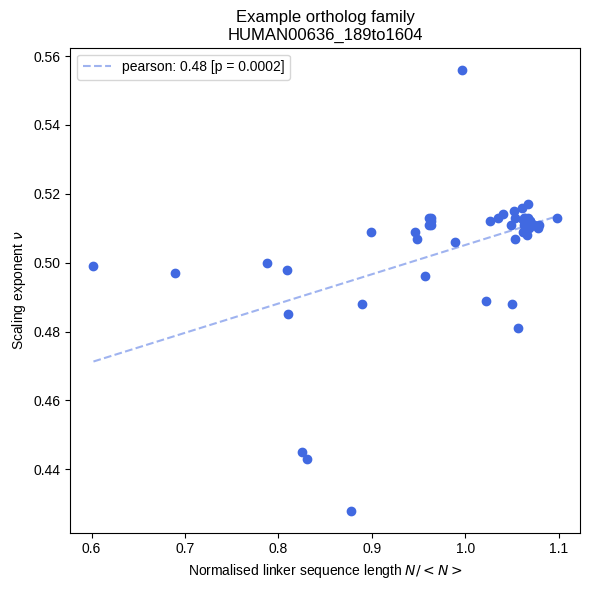

In [341]:
# Checking random ortholog family correlation
example = families.sample(1).iloc[0]

# Correlation
corr, p_corr = pearsonr(example.N, example.nu)

# Plotting correlation
plt.figure(figsize=(6, 6))
plt.scatter(example.N/example.N.mean(), example.nu, c='royalblue')
N = np.array([example.N.min(), example.N.max()]) / example.N.mean()
slope, intersect = np.polyfit(example.N/example.N.mean(), example.nu, 1)
plt.plot(N, N*slope+intersect, c='royalblue', alpha=0.5, linestyle='--', label=f'pearson: {corr:.2f} [p = {p_corr:.4f}]')
plt.legend()
plt.xlabel("Normalised linker sequence length $N/<N>$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title(f"Example ortholog family\n{example.name}")

plt.tight_layout()

In [11]:
# Calculating correlations for all families
def pearson_corr_row(row):
    corr, p = pearsonr(row.N, row.nu)
    row['pcorr'] = corr
    row['pcorr_p'] = p
    return row
def spearman_corr_row(row):
    row['N_lognormalised'] = np.log(row.N/row.N.mean())
    corr, p = spearmanr(row.N_lognormalised, row.nu)
    row['scorr'] = corr
    row['scorr_p'] = p
    return row

families = families.apply(pearson_corr_row, axis=1)
families = families.apply(spearman_corr_row, axis=1)

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Con

Text(0.5, 1.0, 'Distribution of Spearman correlation coefficients\n$ln(\\frac{N}{<N>})$ vs. $\\nu$\n(p < 5.58e-06)')

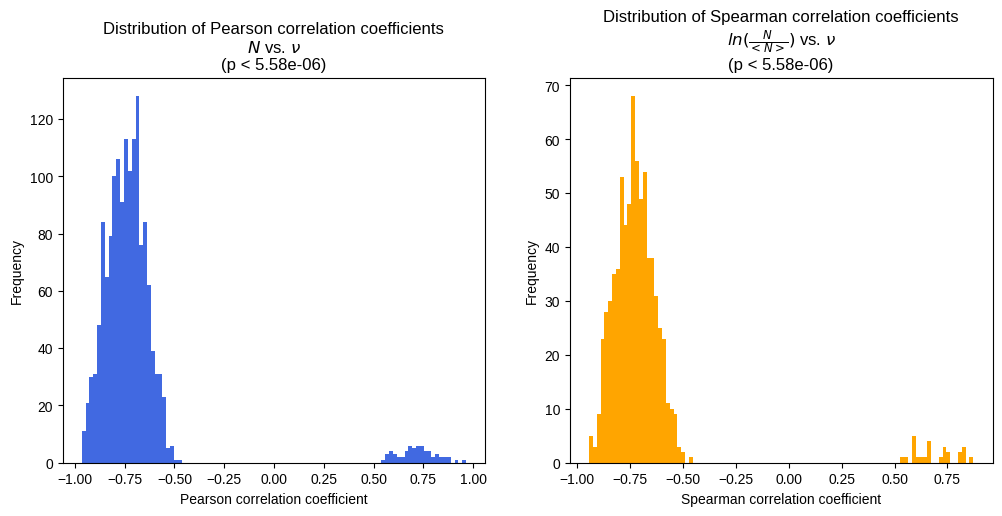

In [37]:
# plotting distribution of correlation coefficients
p_cutoff = 0.05/len(families)

plt.figure(figsize=(12,5))
plt.subplot(121)
families[families.pcorr_p < p_cutoff].pcorr.plot.hist(bins=100, color='royalblue')
plt.xlabel('Pearson correlation coefficient')
plt.title('Distribution of Pearson correlation coefficients'+'\n$N$ vs. $\\nu$'+f'\n(p < {p_cutoff:.2e})')

plt.subplot(122)
families[families.scorr_p < p_cutoff].scorr.plot.hist(bins=100, color='orange')
plt.xlabel('Spearman correlation coefficient')
plt.title('Distribution of Spearman correlation coefficients'+'\n$ln(\\frac{N}{<N>})$ vs. $\\nu$'+f'\n(p < {p_cutoff:.2e})')

Text(0.5, 1.0, 'Volcano plot of Spearman correlation coefficients\n$ln(\\frac{N}{<N>})$ vs. $\\nu$')

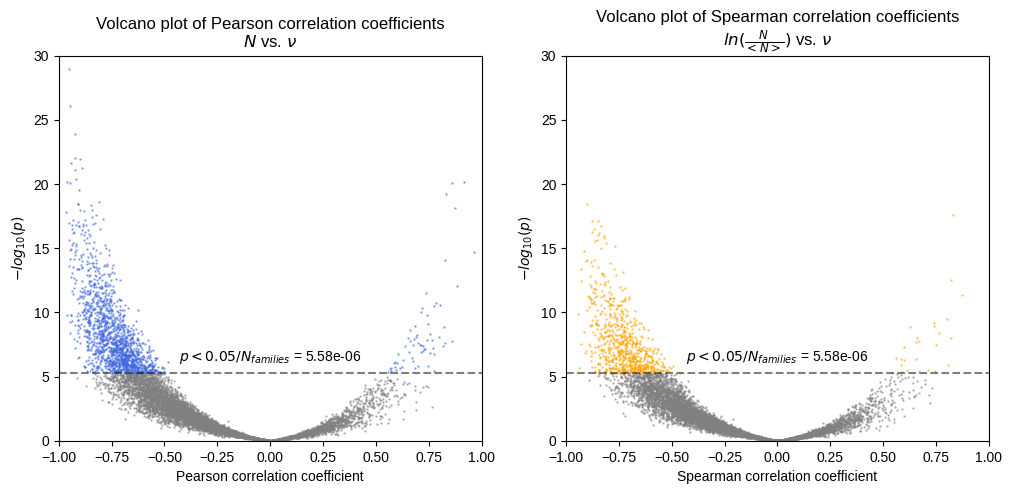

In [50]:
# Volcano plot
p_cutoff = 0.05/len(families)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(families[families.pcorr_p < p_cutoff].pcorr, -np.log10(families[families.pcorr_p < p_cutoff].pcorr_p), alpha=0.5, s=0.6, color='royalblue')
plt.scatter(families[families.pcorr_p >= p_cutoff].pcorr, -np.log10(families[families.pcorr_p >= p_cutoff].pcorr_p), alpha=0.5, s=0.6, color='grey')
plt.hlines(-np.log10(p_cutoff), -1, 1, alpha=0.5, color='k', linestyles='--')
plt.text(0, -np.log10(p_cutoff)+1, '$p < 0.05 / N_{families}$'+f' = {p_cutoff:.2e}', horizontalalignment='center')
plt.xlim(-1,1)
plt.ylim(0,30)
plt.xlabel("Pearson correlation coefficient")
plt.ylabel("$-log_{10}(p)$")
plt.title("Volcano plot of Pearson correlation coefficients"+'\n$N$ vs. $\\nu$')

plt.subplot(122)
plt.scatter(families[families.scorr_p < p_cutoff].scorr, -np.log10(families[families.scorr_p < p_cutoff].scorr_p), alpha=0.5, s=0.6, color='orange')
plt.scatter(families[families.scorr_p >= p_cutoff].scorr, -np.log10(families[families.scorr_p >= p_cutoff].scorr_p), alpha=0.5, s=0.6, color='grey')
plt.hlines(-np.log10(p_cutoff), -1, 1, alpha=0.5, color='k', linestyles='--')
plt.text(0, -np.log10(p_cutoff)+1, '$p < 0.05 / N_{families}$'+f' = {p_cutoff:.2e}', horizontalalignment='center')
plt.xlim(-1,1)
plt.ylim(0,30)
plt.xlabel("Spearman correlation coefficient")
plt.ylabel("$-log_{10}(p)$")
plt.title("Volcano plot of Spearman correlation coefficients"+'\n$ln(\\frac{N}{<N>})$ vs. $\\nu$')

In [350]:
# Checking results
families[families.pcorr_p < p_cutoff].sort_values('pcorr_p').head(20)

,nu,N,pcorr,pcorr_p
HUMAN15493_48to297,"[0.515, 0.543, 0.515, 0.542, 0.517, 0.518, 0.5...","[250, 99, 254, 103, 256, 256, 103, 99, 252, 99...",-0.960684,3.625177e-31
HUMAN26962_287to421,"[0.507, 0.508, 0.541, 0.507, 0.506, 0.54, 0.50...","[135, 135, 64, 135, 135, 64, 135, 135, 135, 64...",-0.946978,8.336729e-27
HUMAN07864_105to241,"[0.524, 0.528, 0.528, 0.528, 0.526, 0.522, 0.5...","[137, 137, 137, 137, 137, 137, 137, 137, 137, ...",-0.924164,1.190964e-24
HUMAN00998_1to100,"[0.495, 0.495, 0.493, 0.494, 0.495, 0.493, 0.5...","[100, 100, 100, 100, 100, 100, 100, 50, 101, 1...",-0.948736,3.936650e-23
HUMAN18141_1692to1803,"[0.522, 0.522, 0.521, 0.521, 0.522, 0.521, 0.5...","[112, 112, 112, 112, 112, 112, 112, 112, 112, ...",-0.922615,9.542045e-23
HUMAN02962_1451to1943,"[0.469, 0.468, 0.468, 0.469, 0.473, 0.466, 0.4...","[493, 493, 493, 493, 493, 493, 493, 493, 493, ...",-0.900971,1.069904e-22
HUMAN00190_328to538,"[0.505, 0.506, 0.507, 0.505, 0.507, 0.527, 0.5...","[211, 211, 211, 211, 211, 93, 211, 211, 211, 2...",-0.888637,5.587509e-22
HUMAN02629_1to75,"[0.506, 0.505, 0.574, 0.508, 0.508, 0.548, 0.5...","[75, 75, 33, 75, 75, 53, 34, 75, 71, 38, 73, 3...",-0.928447,2.066237e-21
HUMAN00757_176to305,"[0.504, 0.501, 0.507, 0.559, 0.547, 0.498, 0.5...","[130, 130, 130, 47, 50, 129, 50, 129, 50, 130,...",-0.916578,3.838649e-21
HUMAN26788_463to1858,"[0.507, 0.507, 0.497, 0.507, 0.508, 0.5, 0.508...","[1396, 1396, 1067, 1396, 1397, 1162, 1397, 139...",0.917702,7.093641e-21


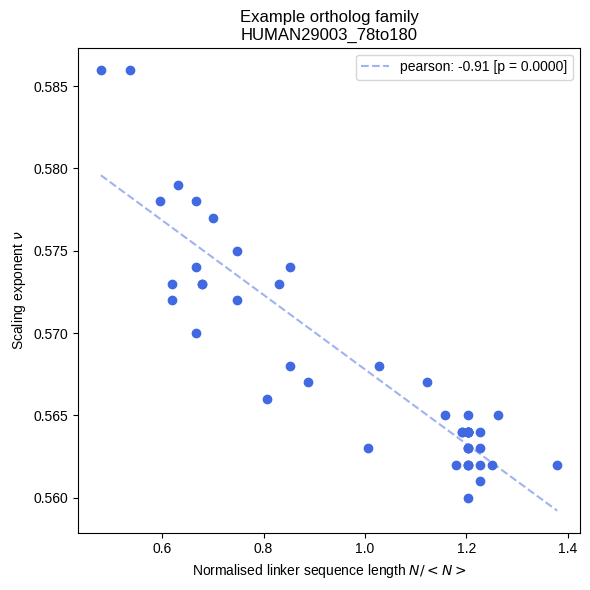

In [374]:
# Checking specific ortholog family
example = families.loc['HUMAN29003_78to180']

# Correlation
corr, p_corr = pearsonr(example.N, example.nu)

# Plotting correlation
plt.figure(figsize=(6, 6))
plt.scatter(example.N/example.N.mean(), example.nu, c='royalblue')
N = np.array([example.N.min(), example.N.max()]) / example.N.mean()
slope, intersect = np.polyfit(example.N/example.N.mean(), example.nu, 1)
plt.plot(N, N*slope+intersect, c='royalblue', alpha=0.5, linestyle='--', label=f'pearson: {corr:.2f} [p = {p_corr:.4f}]')
plt.legend()
plt.xlabel("Normalised linker sequence length $N/<N>$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title(f"Example ortholog family\n{example.name}")

plt.tight_layout()

In [372]:
data[data.HUMAN == 'HUMAN29003_78to180'].set_index('protein')['canonicalid']

protein
HUMAN29003_78to180                  H3BVE4
PANTR44534_78to180              A0A6D2XFP7
NOMLE04650_78to180                  G1RFE4
CALJA00779_78to180              A0A2R8MWF6
PROCO15914_78to180              A0A2K6EK25
SAIBB08947_78to180              A0A2K6T5C3
PIGXX15883_78to180              A0A480DNV8
DASNO05062_78to179      ENSDNOG00000001174
OTOGA15740_78to180                  H0XAS1
TURTR06820_69to173      ENSTTRG00000007597
AILME15677_80to182      ENSAMEG00000016970
VULVU16307_58to159    ENSVVUG00000027357.1
VICPA07108_56to156      ENSVPAG00000000963
BOVIN18877_78to180                  E1BI37
MYOLU04562_56to158                  G1PXA8
ICTTR00398_78to180                  I3NFK0
NANGA07220_78to180              A0A8C6RLN0
RATNO15986_78to180                  Q6QI40
MOUSE32666_78to180                  Z4YLL5
MONDO11959_87to191                  F6U8U6
SARHA10992_56to160      ENSSHAG00000011925
SPHPU14172_78to195              A0A8D0GQG2
CHRPI16961_78to185              A0A8C3PDE1
PHA